Fitted Gompertz–Makeham parameters:
  A = 7.769e-05
  B = 1.156e-07
  C = 0.137

Sample results:
 age     mu_x      m_x      q_x
   0 0.000078 0.000078 0.000078
   1 0.000078 0.000078 0.000078
   2 0.000078 0.000078 0.000078


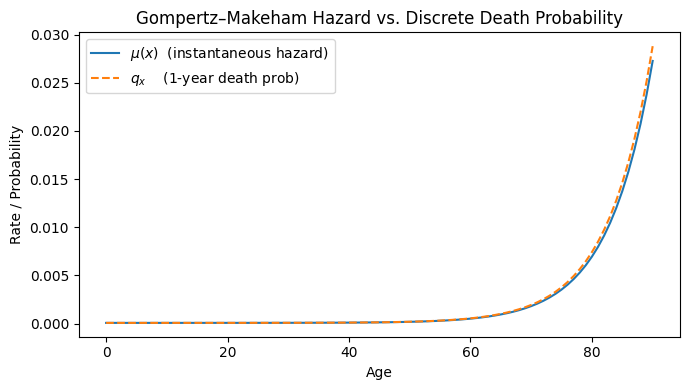

In [ ]:
# TEST to smooth out the death probability using Gompertz–Makeham model - FAILED


date = 2010 # just to fix then it will updated as the simulation goes on

pop_grouped_f = pop_df[pop_df['SEX'] == 'F'].pivot_table(
    index=['AGE_GROUP'],
    columns='YEAR',
    values='POPULATION',
    aggfunc='sum'
).reset_index(drop=True)

pop_grouped_m = pop_df[pop_df['SEX'] == 'M'].pivot_table(
    index=['AGE_GROUP'],
    columns='YEAR',
    values='POPULATION',
    aggfunc='sum'
).reset_index(drop=True)

######################## 

x5 = np.array([0,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90])
D5  = death_df_f[date].to_numpy()
E5  = pop_grouped_f[date].to_numpy()

# --- 2. Define band-integrated hazard M5(x; A,B,C) ---------------
def M5(log_params, x):
    logA, logB, logC = log_params
    A, B, C = np.exp(logA), np.exp(logB), np.exp(logC)
    return A * 5.0 + (B / C) * (np.exp(C * (x + 5)) - np.exp(C * x))

# --- 3. Poisson negative log-likelihood --------------------------
def neg_loglike(log_params):
    M = M5(log_params, x5)
    mu = E5 * M
    # add a tiny epsilon to avoid log(0)
    return -np.sum(D5 * np.log(mu + 1e-12) - mu)

# --- 4. Fit A,B,C by minimizing NLL -------------------------------
init_guess = np.log([1e-4, 1e-5, 0.1])               # A=1e-4, B=1e-5, C=0.1
res = minimize(neg_loglike, init_guess, method='L-BFGS-B')
logA_hat, logB_hat, logC_hat = res.x
A_hat, B_hat, C_hat       = np.exp(res.x)

print(f"Fitted Gompertz–Makeham parameters:\n"
      f"  A = {A_hat:.3e}\n"
      f"  B = {B_hat:.3e}\n"
      f"  C = {C_hat:.3f}")

# --- 5. Compute μ(x) and q_x for single years --------------------
ages = np.arange(int(x5.min()), int(x5.max()) + 1)

# instantaneous hazard at exact age x
mu_x = A_hat + B_hat * np.exp(C_hat * ages)

# integrated 1-year hazard m_x = ∫_x^{x+1} μ(t) dt
m_x = A_hat + (B_hat / C_hat) * (np.exp(C_hat*(ages+1)) - np.exp(C_hat*ages))

# 1-year death probability
q_x = 1 - np.exp(-m_x)

# pack into DataFrame
out = pd.DataFrame({
    'age': ages,
    'mu_x': mu_x,
    'm_x': m_x,
    'q_x': q_x
})
print("\nSample results:")
print(out.head(3).to_string(index=False))

# --- 6. Plot hazard vs. death-probability ------------------------
plt.figure(figsize=(7,4))
plt.plot(ages, mu_x,     label=r'$\mu(x)$  (instantaneous hazard)')
plt.plot(ages, q_x, '--', label=r'$q_x$    (1-year death prob)')
plt.xlabel('Age')
plt.ylabel('Rate / Probability')
# plt.yscale('log')
plt.title('Gompertz–Makeham Hazard vs. Discrete Death Probability')
plt.legend()
plt.tight_layout()
plt.show()

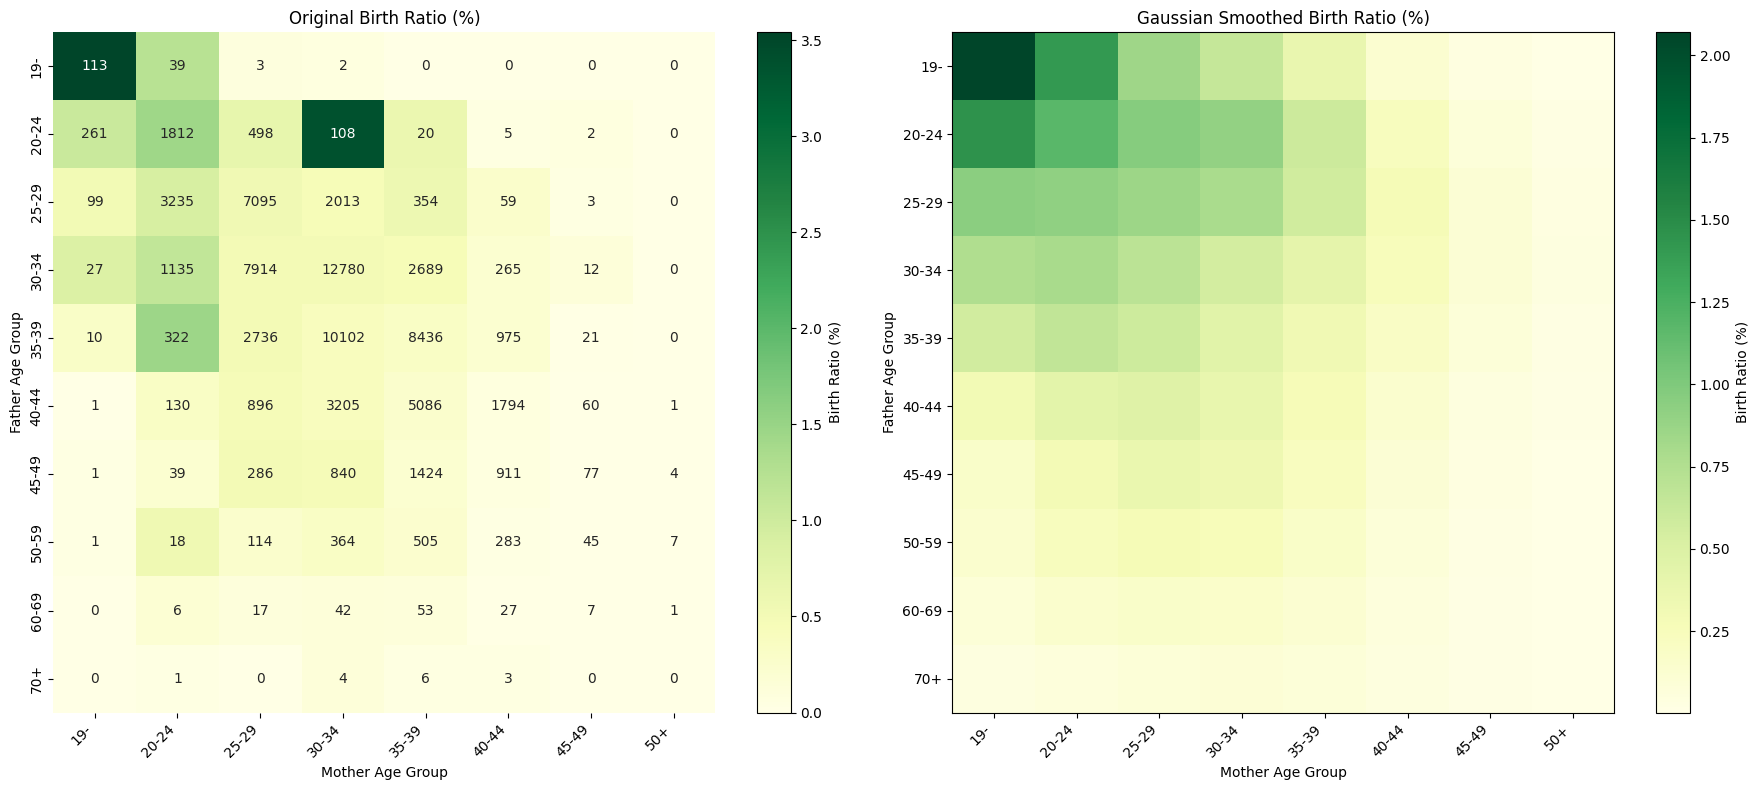

In [ ]:
# TRUE births by father and mother age groups (test of gaussian smoothing of Birth Ratio)

sigma_selected = 1.0  # Adjust sigma for smoothing

# Compute the original heatmap data
heatmap_data = (
    births_df.loc[(births_df['year'] == 2010) & (births_df['father_age_group'] != 'Unknown')]
    .groupby(['father_age_group', 'mother_age_group'])['count']
    .sum()
    .unstack(fill_value=0)
    .div((census_couple_age_groups + 1) * multiplier)
    .round(4)
) * 100

# Apply gaussian smoothing
smoothed_data = pd.DataFrame(
    gaussian_filter(heatmap_data.fillna(0).values, sigma=sigma_selected),
    index=heatmap_data.index,
    columns=heatmap_data.columns
)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Original heatmap
im0 = axes[0].imshow(heatmap_data, cmap='YlGn', aspect='auto')
axes[0].set_title('Original Birth Ratio (%)')
axes[0].set_xlabel('Mother Age Group')
axes[0].set_ylabel('Father Age Group')
axes[0].set_xticks(range(len(heatmap_data.columns)))
axes[0].set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
axes[0].set_yticks(range(len(heatmap_data.index)))
axes[0].set_yticklabels(heatmap_data.index)
# Annotate the original heatmap with the number of births for each cell using imshow's annotation is not directly supported,
# but you can use seaborn.heatmap for built-in annotation support.


# Replace imshow with seaborn.heatmap for the original heatmap
plt.sca(axes[0])
sns.heatmap(
    heatmap_data,
    cmap='YlGn',
    annot=births_df.loc[(births_df['year'] == 2010) & (births_df['father_age_group'] != 'Unknown')]
        .groupby(['father_age_group', 'mother_age_group'])['count']
        .sum()
        .unstack(fill_value=0)
        .reindex(index=heatmap_data.index, columns=heatmap_data.columns)
        .astype(int),
    fmt="d",
    cbar=False,
    ax=axes[0]
)
axes[0].set_title('Original Birth Ratio (%)')
axes[0].set_xlabel('Mother Age Group')
axes[0].set_ylabel('Father Age Group')
axes[0].set_xticklabels(heatmap_data.columns, rotation=45, ha='right')
axes[0].set_yticklabels(heatmap_data.index)
fig.colorbar(im0, ax=axes[0], label='Birth Ratio (%)')

# Smoothed heatmap
im1 = axes[1].imshow(smoothed_data, cmap='YlGn', aspect='auto')
axes[1].set_title('Gaussian Smoothed Birth Ratio (%)')
axes[1].set_xlabel('Mother Age Group')
axes[1].set_ylabel('Father Age Group')
axes[1].set_xticks(range(len(smoothed_data.columns)))
axes[1].set_xticklabels(smoothed_data.columns, rotation=45, ha='right')
axes[1].set_yticks(range(len(smoothed_data.index)))
axes[1].set_yticklabels(smoothed_data.index)
fig.colorbar(im1, ax=axes[1], label='Birth Ratio (%)')

plt.tight_layout()
plt.show()




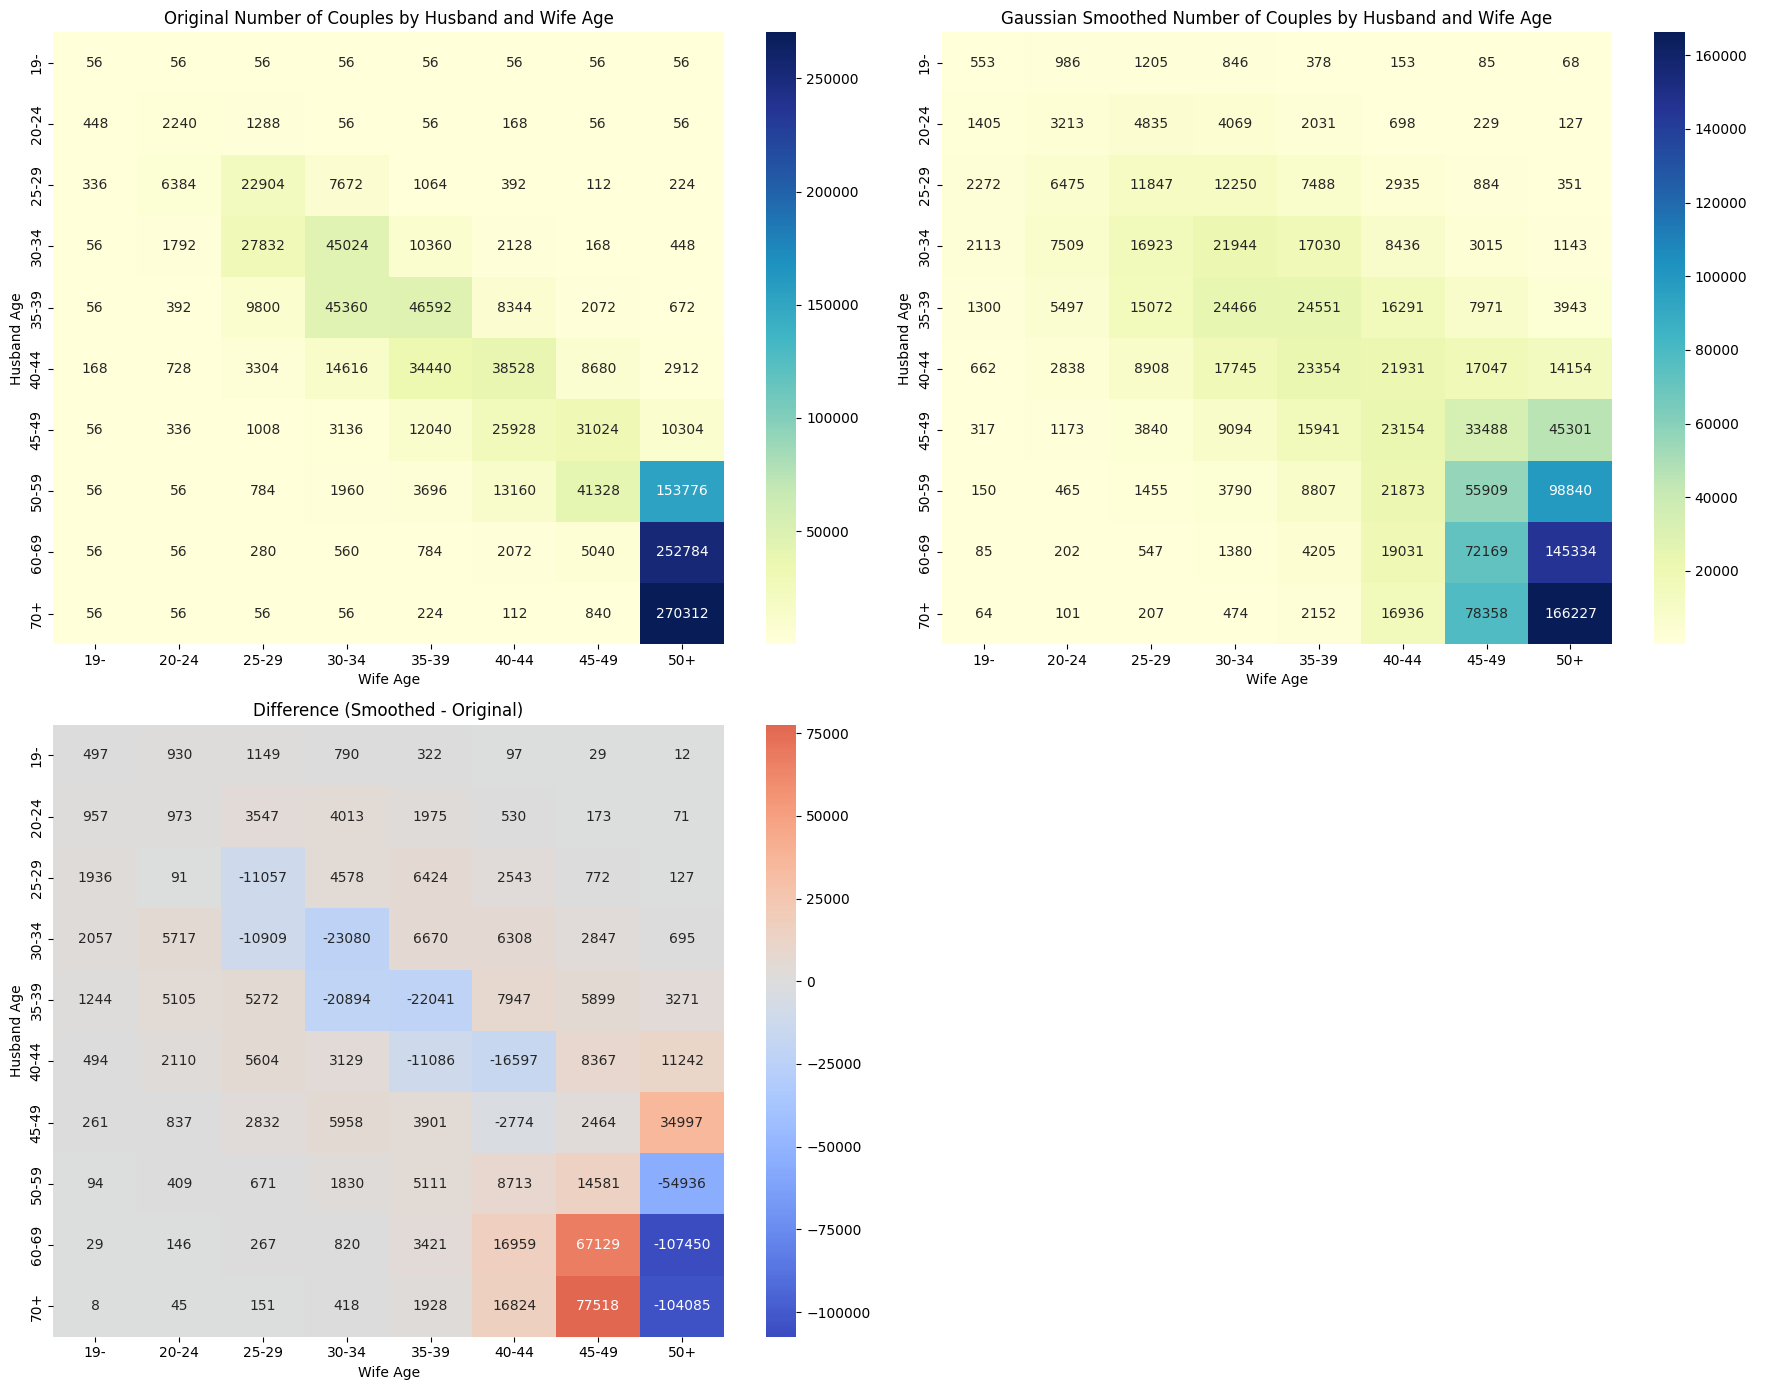

In [ ]:
# Gaussian Smoothing TEST 
# Convert to numpy array for smoothing, fill NaNs with 0

selected_sigma = 1  # Adjust this value to control the amount of smoothing

census_couples_counts_smoothed = pd.DataFrame(
    gaussian_filter(census_couple_age_groups.fillna(0).values, sigma=selected_sigma),
    index=census_couple_age_groups.index,
    columns=census_couple_age_groups.columns
)
# Optionally, round to integers if you want counts
census_couples_counts_smoothed = census_couples_counts_smoothed.round(0)

# Plot the original couples_counts heatmap next to the smoothed one
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# Original with annotation
sns.heatmap(
    census_couple_age_groups, 
    cmap="YlGnBu", 
    annot=census_couple_age_groups, 
    fmt=".0f", 
    ax=axes[0, 0]
)
axes[0, 0].set_title("Original Number of Couples by Husband and Wife Age")
axes[0, 0].set_xlabel("Wife Age")
axes[0, 0].set_ylabel("Husband Age")

# Smoothed with annotation (original counts)
sns.heatmap(
    census_couples_counts_smoothed, 
    cmap="YlGnBu", 
    annot=census_couples_counts_smoothed, 
    fmt=".0f", 
    ax=axes[0, 1]
)
axes[0, 1].set_title("Gaussian Smoothed Number of Couples by Husband and Wife Age")
axes[0, 1].set_xlabel("Wife Age")
axes[0, 1].set_ylabel("Husband Age")

# Difference (Smoothed - Original) with annotation (original counts)
diff = census_couples_counts_smoothed - census_couple_age_groups
sns.heatmap(
    diff, 
    cmap="coolwarm", 
    center=0, 
    annot=diff, 
    fmt=".0f", 
    ax=axes[1, 0]
)
axes[1, 0].set_title("Difference (Smoothed - Original)")
axes[1, 0].set_xlabel("Wife Age")
axes[1, 0].set_ylabel("Husband Age")

# Hide the unused subplot
axes[1, 1].axis('off')

plt.tight_layout()
plt.show()

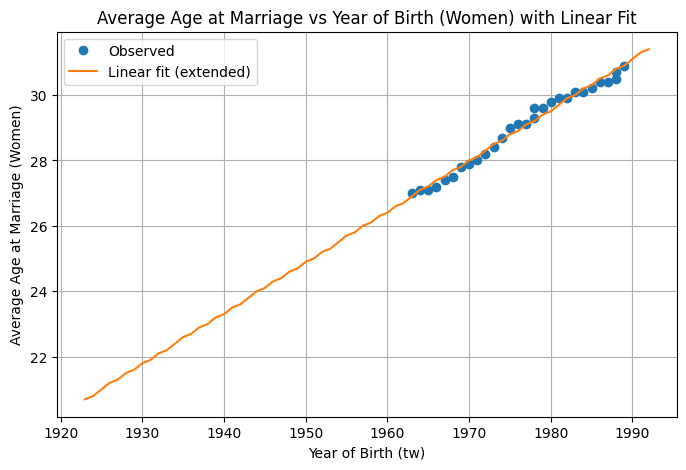

In [ ]:
# Linear regression for average age at marriage for given year of birth (women)
# Plot original and extended line
plt.figure(figsize=(8, 5))
plt.plot(mean_obs['tw'], mean_obs['avg_age_w'], 'o', label='Observed')
plt.plot(tw_extended, avg_age_pred, '-', label='Linear fit (extended)')
plt.xlabel('Year of Birth (tw)')
plt.ylabel('Average Age at Marriage (Women)')
plt.title('Average Age at Marriage vs Year of Birth (Women) with Linear Fit')
plt.legend()
plt.grid(True)
plt.show()

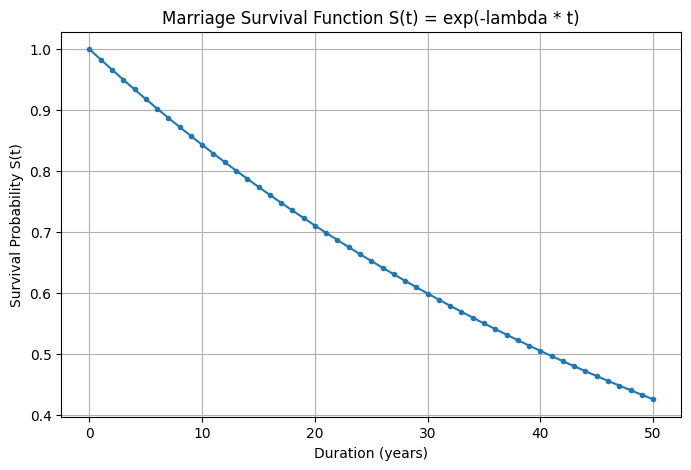

In [ ]:
# Plot the survival function S(t) = exp(-lambda_exp * t) for marriage durations 0 to 50 years --> used to estimate marriage date

durations = np.arange(0, 51)  # durations from 0 to 50 years
S = np.exp(-lambda_alt* durations)

plt.figure(figsize=(8, 5))
plt.plot(durations, S, marker='.')
plt.xlabel('Duration (years)')
plt.ylabel('Survival Probability S(t)')
plt.title('Marriage Survival Function S(t) = exp(-lambda * t)')
plt.grid(True)
plt.show()


In [ ]:
# NOT SURE IT MAKES SENSE --> project number of deaths per age category (not probability)
# it would make more sense to project the probability (or the life expectancy) rather than the number of deaths
# here as the population is not constant if we divide the number of deaths by the population (shrinking) we would get irrealistic values


# i want to have one row for each year and age group and one column for each year 

death_df_f = death_df[death_df['SEX'] == 'F'].pivot_table(
    index=['AGE_GROUP'],
    columns='YEAR',
    values='OBS_VALUE',
    aggfunc='sum'
).reset_index()

death_df_m = death_df[death_df['SEX'] == 'M'].pivot_table(
    index=['AGE_GROUP'],
    columns='YEAR',
    values='OBS_VALUE',
    aggfunc='sum'
).reset_index()



def project_deaths_until(df, target_year):
    """
    Projects the deaths for each age group until the specified target_year (inclusive).
    Adds new columns for each projected year.
    """
    # Get the list of years (columns) as integers, excluding 'AGE'
    year_cols = [col for col in df.columns if col != 'AGE_GROUP']
    # Ensure all year columns are integers for regression
    year_cols_int = [int(col) for col in year_cols]
    year_cols_int.sort()
    last_year = year_cols_int[-1]
    assert target_year > last_year, "target_year must be greater than the last year in the dataset"

    for year in range(last_year + 1, target_year + 1):
        projections = []
        for idx, row in df.iterrows():
            # Always use the current columns for regression
            current_year_cols = [col for col in df.columns if col != 'AGE_GROUP']
            # Only keep columns that are actually integers (years)
            current_year_cols_int = [col for col in current_year_cols if isinstance(col, int)]
            current_year_cols_int.sort()
            X = np.array(current_year_cols_int).reshape(-1, 1)
            y = row[current_year_cols_int].values.astype(float)
            model = LinearRegression().fit(X, y)
            y_pred = model.predict(np.array([[year]]))
            projections.append(int(round(y_pred[0])))
        df[str(year)] = projections  # Add new year as string column

    return df

death_df_m = project_deaths_until(death_df_m, 2026)

In [ ]:
# TEST WITH NO PARITY

# Define bins and labels for women and men age groups <-- from available data
birth_age_bins_w = [0, 20, 25, 30, 35, 40, 45, 50, 200]
birth_age_labels_w = ['19-', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50+']

birth_age_bins_m = [0, 20, 25, 30, 35, 40, 45, 50, 60, 70, 200]
birth_age_labels_m = ['19-', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-59', '60-69', '70+']


####### NUMERATOR #######

births_df = pd.read_csv('data/bfs_births_2000_2023_kid_order_parents_ages.csv', delimiter=',')

# rename the columns
births_df.rename(columns={
    'Year' : 'year',
    'Birth order': 'birth_order', 
    'Age class of father': 'father_age_group',
    'Age class of mother': 'mother_age_group',
    'Live births': 'count'
}, inplace=True)    

# replace values in the 'birth order' column with the corresponding numbers
births_df['father_age_group'] = births_df['father_age_group'].replace(
    {'Less than 20 years': '19-', '20-24 years': '20-24', '25-29 years': '25-29', '30-34 years': '30-34',
    '35-39 years': '35-39', '40-44 years': '40-44', '45-49 years': '45-49', '50-59 years': '50-59', '60-69 years': '60-69',
    '70 years or more': '70+', 'Unknown': 'Unknown'})

births_df['mother_age_group'] = births_df['mother_age_group'].replace(
    {'Less than 20 years': '19-', '20-24 years': '20-24', '25-29 years': '25-29', '30-34 years': '30-34',
    '35-39 years': '35-39', '40-44 years': '40-44', '45-49 years': '45-49', '50 years or more': '50+'})


# If there are duplicate rows (same year, birth_order, father_age_group, mother_age_group), sum the 'count' column 
# --> to unify 45-49 and 50+ yo mothers categories
births_df = births_df.groupby(['year', 'father_age_group', 'mother_age_group'], as_index=False)['count'].sum()


####### DENOMINATOR #######

# import census data to compute number of woman married to men in given age group
file_name = f'data/hh_rw_' + str(date) + '_ms.csv'
census_df = pd.read_csv(file_name, delimiter=',')


# import population_counts data --> to get multiplication factor of census to true population 
pop_counts_df = pd.read_csv('data/bfs_population_count.csv', delimiter=',')
pop_counts_df.rename(columns={'Year': 'year', 'Sex':'sex', 'Age':'age', 'Population': 'population'}, inplace=True)

# multiplier to get the population counts from the census data --> being a sample 
multiplier = round(pop_counts_df.loc[pop_counts_df.year == 2010].population.sum()/len(census_df))
if to_print:
    print(f"multiply absolute values of census by {multiplier} to get the population counts")



# TRANSFORM data to extract population count of couples (given age group of mother and age group of father)

# filter couples in the census data
census_couples = census_df.loc[census_df.htype.isin([210, 220]) & (census_df.role.isin([1,2]))]

# group by age groups and count the number of census_couples whose husband (gender = 1) is in the given age group and wife (gender = 2) is in the given age group 
census_husbands = census_couples[census_couples['gender'] == 1][['hid', 'age']].rename(columns={'age': 'husband_age'})
census_wives = census_couples[census_couples['gender'] == 2][['hid', 'age']].rename(columns={'age': 'wife_age'})

census_husbands['husband_age_group'] = pd.cut(census_husbands['husband_age'], bins=birth_age_bins_m, labels=birth_age_labels_m, right=False)
census_wives['wife_age_group'] = pd.cut(census_wives['wife_age'], bins=birth_age_bins_w, labels=birth_age_labels_w, right=False)

# Merge on household id to get census_couples
census_couple_age_groups = pd.merge(census_husbands, census_wives, on='hid')

# Count number of census_couples by (husband_age_group, wife_age_group)
census_couple_age_groups = census_couple_age_groups.groupby(['husband_age_group', 'wife_age_group']).size().unstack(fill_value=0)

# add 1 to avoid division by zero in the next step and multiply by the multiplier to get the population counts (instead of sample counts)
census_couple_age_groups = (census_couple_age_groups + 1)*multiplier


exploded_census_couples = census_couple_age_groups.reset_index().melt(
    id_vars='husband_age_group',
    var_name='wife_age_group',
    value_name='count'
)




####### NUMERATOR/DENOMINATOR #######

# merge NUMERATOR and DENOMINATOR to get the birth ratio 
birth_ratio = exploded_census_couples.merge(
    births_df.loc[births_df.year == date], 
    left_on = ['husband_age_group', 'wife_age_group'],
    right_on = ['father_age_group', 'mother_age_group'], how='left',
    suffixes=('_census', '_births')
)
birth_ratio = birth_ratio[['husband_age_group', 'wife_age_group', 'count_census', 'count_births']]

# birth_ratio['birth_ratio'] = birth_ratio.apply(
#    lambda row: row['count_births'] / row['count_census'] if row['count_census'] != 0 else 0, axis=1)

birth_ratio['count_census'].replace(0, 0.001, inplace=True)  # to avoid division by zero
birth_ratio['birth_ratio'] = birth_ratio['count_births'] / birth_ratio['count_census']





#### BIRTH PROBABILITY CALCULATION - using Binomial regression #### 

# Calculate the birth probability for each combination of husband, wife age groups and parity using Binomial regression
birth_probability = pd.get_dummies(birth_ratio, columns=['husband_age_group', 'wife_age_group'], drop_first=False, dtype=float)

X_cols = [c for c in birth_probability.columns 
          if c.startswith('husband_age_group_') 
          or c.startswith('wife_age_group_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = birth_probability[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    birth_probability['count_births'],
    birth_probability['count_census'] - birth_probability['count_births']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
birth_probability['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'wife_age_group' from dummies
wife_age_group_cols = [col for col in birth_probability.columns if col.startswith('wife_age_group_')]
birth_probability['wife_age_group'] = birth_probability[wife_age_group_cols].idxmax(axis=1).str.replace('wife_age_group_', '')

# Recover 'husband_age_group' from dummies
husband_age_group_cols = [col for col in birth_probability.columns if col.startswith('husband_age_group_')]
birth_probability['husband_age_group'] = birth_probability[husband_age_group_cols].idxmax(axis=1).str.replace('husband_age_group_', '')


birth_probability.drop(columns=X_cols, inplace=True)
birth_probability = birth_probability[['wife_age_group', 'husband_age_group', 'count_births',
                                        'count_census', 'birth_ratio', 'p_hat_binom']]





multiply absolute values of census by 56 to get the population counts
                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   80
Model:                            GLM   Df Residuals:                       63
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Wed, 04 Jun 2025   Deviance:                       7059.5
Time:                        16:07:16   Pearson chi2:                 3.53e+03
No. Iterations:                    14   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [ ]:
#### OLD LAMBDA CALCULATION ### 

divorces_ratios_df = pd.read_csv('data/bfs_divorces_ratios.csv', delimiter=';').replace(
    ',', '.', regex=True)
divorces_ratios_df = divorces_ratios_df.astype(float)

divorces_duration_avg_df = pd.read_csv('data/bfs_divorces_duration_avg.csv', delimiter=';').replace(
    ',', '.', regex=True)
divorces_duration_avg_df = divorces_duration_avg_df.astype(float)

life_expectancy_df = pd.read_csv('data/bfs_life_expectancy_at_birth_sex.csv')
life_expectancy_m = life_expectancy_df.loc[life_expectancy_df.year == date]['M'].values[0]
life_expectancy_f = life_expectancy_df.loc[life_expectancy_df.year == date]['F'].values[0]

mean_age_at_marriage_df = pd.read_csv('data/bfs_avg_age_marriage_sex.csv', delimiter=';').iloc[:,:3]
mean_age_at_marriage_m = mean_age_at_marriage_df.loc[mean_age_at_marriage_df.year == date]['M'].values[0]
mean_age_at_marriage_f = mean_age_at_marriage_df.loc[mean_age_at_marriage_df.year == date]['F'].values[0]

D_m = life_expectancy_m - mean_age_at_marriage_m
D_f = life_expectancy_f - mean_age_at_marriage_f

A = divorces_ratios_df.loc[divorces_ratios_df.year == date,'tot_divorce_ratio'].values[0]/100
B = divorces_duration_avg_df.loc[divorces_duration_avg_df.year == date, 'avg_duration'].values[0] 
C = 1 - A
D = (D_m + D_f) / 2 

avg_marriage_duration = (A * B + C * D)
lambda_exp = 1 / avg_marriage_duration

In [ ]:
#### MARRIAGE PROBABILITY CALCULATION (ALL IN ONE) - using Binomial regression #### 

# Calculate the marriage probability for each combination of husband, wife age groups and previous_marriages using Binomial regression
marriage_prob = pd.get_dummies(marriage_ratio, columns=['age_group_m', 'age_group_w', 'previous_marriages'],
                                drop_first=False, dtype=float)

X_cols = [c for c in marriage_prob.columns 
          if c.startswith('age_group_m_') 
          or c.startswith('age_group_w_')
          or c.startswith('previous_marriages_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = marriage_prob[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    marriage_prob['marriages_count'],
    marriage_prob['census_count'] - marriage_prob['marriages_count']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
marriage_prob['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'age_group_w' from dummies
age_group_w_cols = [col for col in marriage_prob.columns if col.startswith('age_group_w_')]
marriage_prob['age_group_w'] = marriage_prob[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

# Recover 'age_group_m' from dummies
age_group_m_cols = [col for col in marriage_prob.columns if col.startswith('age_group_m_')]
marriage_prob['age_group_m'] = marriage_prob[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

# Recover 'previous_marriages' from dummies
previous_marriages_cols = [col for col in marriage_prob.columns if col.startswith('previous_marriages_')]
marriage_prob['previous_marriages'] = marriage_prob[previous_marriages_cols].idxmax(axis=1).str.replace('previous_marriages_', '')

marriage_prob.drop(columns=X_cols, inplace=True)
marriage_prob = marriage_prob[['age_group_w', 'age_group_m', 'previous_marriages', 'marriages_count', 'census_count', 'marriage_ratio', 'p_hat_binom']]


                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  128
Model:                            GLM   Df Residuals:                      112
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:                Thu, 12 Jun 2025   Deviance:                       29395.
Time:                        15:42:13   Pearson chi2:                 1.22e+04
No. Iterations:                    14   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -1.2338 

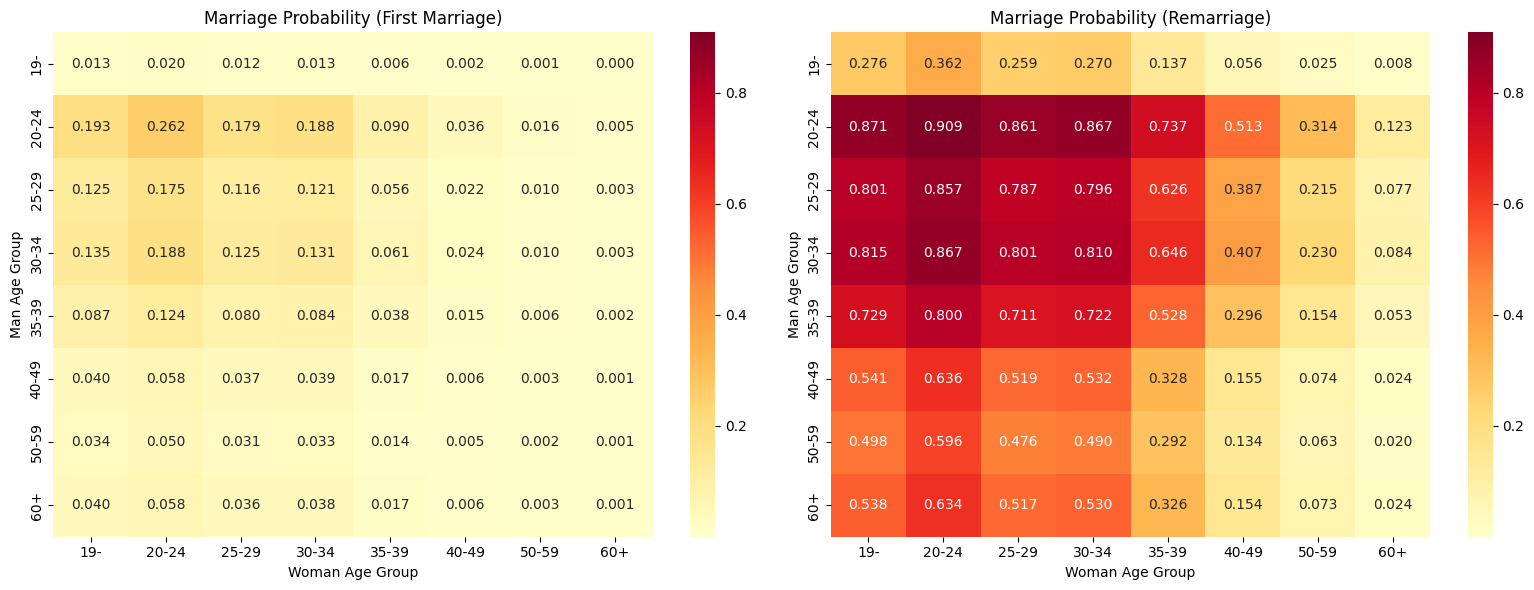

In [ ]:
# HEATMAPS OF MARRIAGE PROBABILITY - (INCLUDE Previous Marriages Factor)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Marriage Probability (First Marriage)', 'Marriage Probability (Remarriage)']

# Prepare heatmaps using marriage_prob and multiply probability by previous_marriages factor

# First marriage (previous_marriages = 0)
heatmap_1st = marriage_prob[marriage_prob['previous_marriages'] == '0'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom', fill_value=0
)

# Remarriage (previous_marriages = 1)
heatmap_remarriage = marriage_prob[marriage_prob['previous_marriages'] == '1'].pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom', fill_value=0
)


vmin = min(heatmap_1st.min().min(), heatmap_remarriage.min().min())
vmax = max(heatmap_1st.max().max(), heatmap_remarriage.max().max())


# For first marriage, previous_marriages factor is 1 (no change)
sns.heatmap(
    heatmap_1st,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[0],
    vmin=vmin,
    vmax=vmax
)
axes[0].set_title(titles[0])
axes[0].set_xlabel('Woman Age Group')
axes[0].set_ylabel('Man Age Group')

# For remarriage, multiply probability by previous_marriages factor (which is 1 here, so no change)
sns.heatmap(
    heatmap_remarriage,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
    vmin=vmin,
    vmax=vmax
)
axes[1].set_title(titles[1])
axes[1].set_xlabel('Woman Age Group')
axes[1].set_ylabel('Man Age Group')

plt.tight_layout()
plt.show()

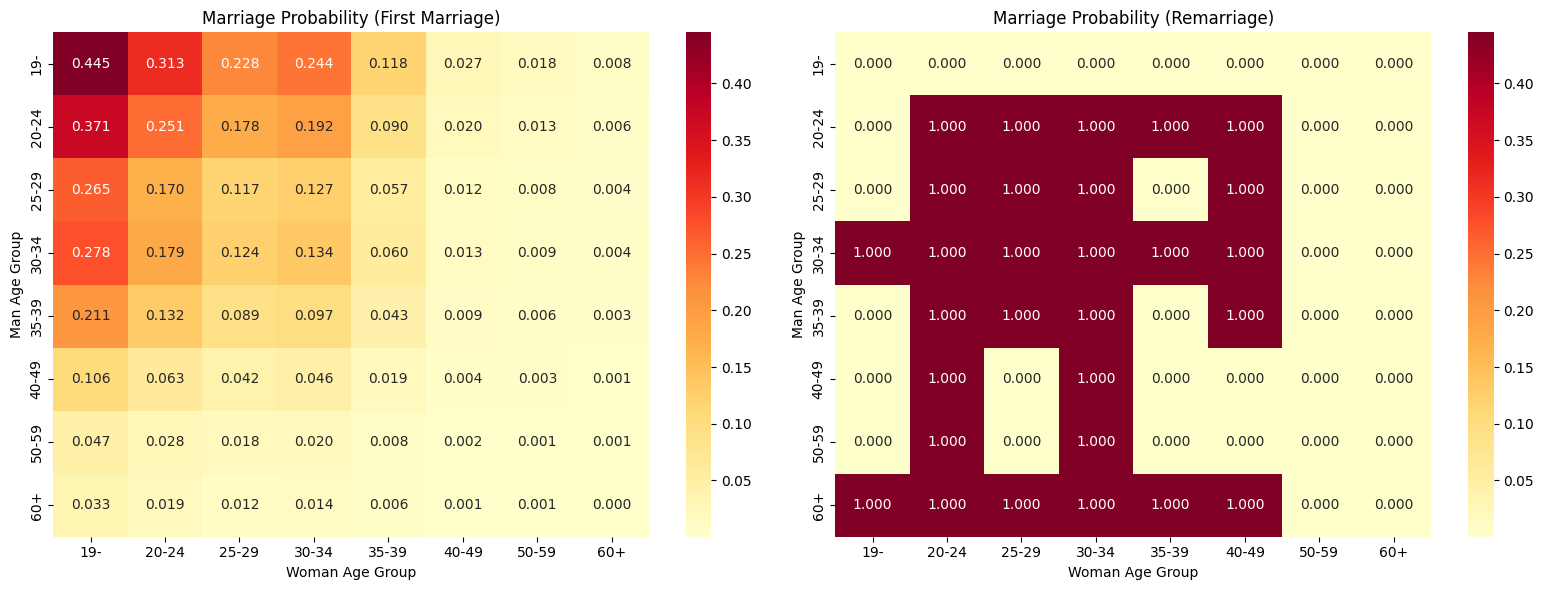

In [ ]:
# HEATMAPS OF MARRIAGE PROBABILITY - (SEPARATE First Marriage vs Remarriage)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))
titles = ['Marriage Probability (First Marriage)', 'Marriage Probability (Remarriage)']

# First marriage (previous_marriages = 0)
heatmap_1st = marriage_prob_1st.pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom', fill_value=0
)
sns.heatmap(
    heatmap_1st,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[0],
    vmin=heatmap_1st.min().min(),
    vmax=heatmap_1st.max().max()
)
axes[0].set_title(titles[0])
axes[0].set_xlabel('Woman Age Group')
axes[0].set_ylabel('Man Age Group')

# Remarriage (previous_marriages = 1)
heatmap_remarriage = marriage_prob_remarriage.pivot_table(
    index='age_group_m', columns='age_group_w', values='p_hat_binom', fill_value=0
)
sns.heatmap(
    heatmap_remarriage,
    cmap="YlOrRd",
    annot=True,
    fmt=".3f",
    ax=axes[1],
    vmin=heatmap_1st.min().min(),
    vmax=heatmap_1st.max().max()
)
axes[1].set_title(titles[1])
axes[1].set_xlabel('Woman Age Group')
axes[1].set_ylabel('Man Age Group')

plt.tight_layout()
plt.show()


In [ ]:
#### MARRIAGE PROBABILITY CALCULATION (1st Marriage) - using Binomial regression #### 

# Calculate the marriage probability for each combination of husband, wife age groups and previous_marriages using Binomial regression
marriage_prob_1st = pd.get_dummies(marriage_ratio_1st, columns=['age_group_m', 'age_group_w'], drop_first=False, dtype=float)

X_cols = [c for c in marriage_prob_1st.columns 
          if c.startswith('age_group_m_') 
          or c.startswith('age_group_w_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = marriage_prob_1st[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    marriage_prob_1st['marriages_count'],
    marriage_prob_1st['census_count'] - marriage_prob_1st['marriages_count']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
marriage_prob_1st['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'age_group_w' from dummies
age_group_w_cols = [col for col in marriage_prob_1st.columns if col.startswith('age_group_w_')]
marriage_prob_1st['age_group_w'] = marriage_prob_1st[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

# Recover 'age_group_m' from dummies
age_group_m_cols = [col for col in marriage_prob_1st.columns if col.startswith('age_group_m_')]
marriage_prob_1st['age_group_m'] = marriage_prob_1st[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

marriage_prob_1st.drop(columns=X_cols, inplace=True)
marriage_prob_1st = marriage_prob_1st[['age_group_w', 'age_group_m', 'marriages_count', 'census_count', 'marriage_ratio', 'p_hat_binom']]


                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   64
Model:                            GLM   Df Residuals:                       49
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -725.48
Date:                Thu, 12 Jun 2025   Deviance:                       1138.1
Time:                        15:07:30   Pearson chi2:                 1.37e+03
No. Iterations:                    12   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -2.8534      0.02

In [ ]:
#### MARRIAGE PROBABILITY CALCULATION (Remarriage) - using Binomial regression #### 

# Calculate the marriage probability for each combination of husband, wife age groups and previous_marriages using Binomial regression
marriage_prob_remarriage = pd.get_dummies(marriage_ratio_remarriage, columns=['age_group_m', 'age_group_w'], drop_first=False, dtype=float)

X_cols = [c for c in marriage_prob_remarriage.columns 
          if c.startswith('age_group_m_') 
          or c.startswith('age_group_w_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = marriage_prob_remarriage[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    marriage_prob_remarriage['marriages_count'],
    marriage_prob_remarriage['census_count'] - marriage_prob_remarriage['marriages_count']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
marriage_prob_remarriage['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'age_group_w' from dummies
age_group_w_cols = [col for col in marriage_prob_remarriage.columns if col.startswith('age_group_w_')]
marriage_prob_remarriage['age_group_w'] = marriage_prob_remarriage[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

# Recover 'age_group_m' from dummies
age_group_m_cols = [col for col in marriage_prob_remarriage.columns if col.startswith('age_group_m_')]
marriage_prob_remarriage['age_group_m'] = marriage_prob_remarriage[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

marriage_prob_remarriage.drop(columns=X_cols, inplace=True)
marriage_prob_remarriage = marriage_prob_remarriage[['age_group_w', 'age_group_m', 'marriages_count', 'census_count', 'marriage_ratio', 'p_hat_binom']]


                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   64
Model:                            GLM   Df Residuals:                       49
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 12 Jun 2025   Deviance:                   1.2001e+06
Time:                        15:07:32   Pearson chi2:                 2.42e+19
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              -2.58e+14   5.66e+0

In [ ]:
#### DIVORCE (age groups, duration) RATIO #### 
# assumptions: same age distribution for couples with and without children for lack of data

#### NUMERATOR ####
# Read divorce data
divorce_df = pd.read_csv('data/bfs_divorces_age_groups_duration_2000_2023.csv', delimiter=';', encoding='latin1')
divorce_df[['age_group_m', 'age_group_w']] = divorce_df[['age_group_m', 'age_group_w']].replace(
    {'Less than 20 years':'19-', '20-29 years':'20-29', '30-39 years':'30-39', 
	'40-49 years':'40-49', '50-59 years':'50-59', '60-69 years':'60-69', 
	'70-79 years':'70-79', '80-89 years':'80-89','90 years or more':'90+'})

divorce_df['duration'] = divorce_df['duration'].replace(
    {'0-4 years':'0-4', '5-9 years':'5-9', '10-14 years':'10-14', 
     '15-19 years':'15-19', '20 years or more':'20+'})
divorce_df_year = divorce_df.loc[divorce_df.year == initial_date]

### DENOMINATOR ####
divorce_couples = pd.read_csv('data/' + str(initial_date) + '_census_married_year.csv', delimiter=';')

divorce_age_bins = [0, 20, 30, 40, 50, 60, 70, 80, 90, 200]
divorce_age_labels = ['19-', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']

marriage_duration_bins = [0, 5, 10, 15, 20, 100]
marriage_duration_labels = ['0-4', '5-9', '10-14', '15-19', '20+']

divorce_couples['marriage_duration'] = initial_date - divorce_couples['marriage_date']
divorce_couples['marriage_duration_group'] = pd.cut(divorce_couples['marriage_duration'], bins=marriage_duration_bins, 
                                                    labels=marriage_duration_labels, right=False)

# group by age groups and count the number of divorce_couples whose husband (gender = 1) is in the given age group and wife (gender = 2) is in the given age group 
census_m = divorce_couples[divorce_couples['gender'] == 'M'][
    ['household_id', 'age','children_in_hh','marriage_duration_group']].rename(columns={'age': 'age_m'})
census_w = divorce_couples[divorce_couples['gender'] == 'F'][
    ['household_id', 'age']].rename(columns={'age': 'age_w'})   

census_m['age_group_m'] = pd.cut(census_m['age_m'], bins=divorce_age_bins, labels=divorce_age_labels, right=False)
census_w['age_group_w'] = pd.cut(census_w['age_w'], bins=divorce_age_bins, labels=divorce_age_labels, right=False)

# Merge on household id to get divorce_couples
divorce_couple_age_groups = pd.merge(census_m, census_w, on='household_id')
divorce_couple_age_groups = divorce_couple_age_groups[['age_group_m','age_group_w','children_in_hh','marriage_duration_group']]

# check if children are present
divorce_couple_age_groups['children'] = (divorce_couple_age_groups['children_in_hh']>0).astype(int)

divorce_census_couple_count = divorce_couple_age_groups[
    ['age_group_m','age_group_w','marriage_duration_group']].reset_index().groupby([
        'age_group_m','age_group_w','marriage_duration_group']).size().reset_index(name='count')

# adjust the counts to get the population counts (instead of sample counts)
divorce_census_couple_count['census_count'] = (divorce_census_couple_count['count'] + 1) * divorce_couples_multiplier




####### NUMERATOR / DENOMINATOR #######
# to get the marriage ratio
divorce_ratio = divorce_df_year.merge(divorce_census_couple_count, 
    left_on=['age_group_m', 'age_group_w', 'duration'], 
    right_on=['age_group_m', 'age_group_w', 'marriage_duration_group'], how='inner')
divorce_ratio = divorce_ratio.rename(columns={'divorces': 'divorces_count'})

divorce_ratio = divorce_ratio[['age_group_m', 'age_group_w', 'duration', 'census_count', 'divorces_count']]
divorce_ratio['census_count'].replace(0, 0.001, inplace=True)
divorce_ratio['divorce_ratio'] = divorce_ratio.apply(
   lambda row: row['divorces_count'] / row['census_count'] if row['census_count'] != 0 else 0, axis=1)

divorce_split_duration = {}
for i,duration in enumerate(divorce_ratio['duration'].unique()):
    divorce_split_duration[i] = divorce_ratio.loc[divorce_ratio['duration'] == duration].copy()

In [ ]:
#### DIVORCE (age groups, duration) PROBABILITY CALCULATION - SPLIT DURATION ####

# Calculate the divorce probability for each combination of husband, wife age groups using Binomial regression
divorce_probability_split = {}
for i,duration in enumerate(divorce_ratio['duration'].unique()):
    divorce_probability = pd.get_dummies(divorce_split_duration[i], 
                                                  columns=['age_group_m', 'age_group_w'],
                                                  drop_first=False, dtype=float)

    X_cols = [c for c in divorce_probability.columns 
            if c.startswith('age_group_m_') 
            or c.startswith('age_group_w_')]

    # Convert boolean columns to int (0/1) for statsmodels
    Xb = divorce_probability[X_cols].astype(float)
    Xb = sm.add_constant(Xb)

    endog = np.vstack([
        divorce_probability['divorces_count'],
        divorce_probability['census_count'] - divorce_probability['divorces_count']
    ]).T

    binom_mod = sm.GLM(
        endog,
        Xb,
        family=sm.families.Binomial()
    )
    binom_res = binom_mod.fit()
    divorce_probability['p_hat_binom'] = binom_res.predict(Xb)


    # print summary of the binomial regression model
    if to_print:
        print(binom_res.summary())
    

    # Recover 'age_group_w' from dummies
    age_group_w_cols = [col for col in divorce_probability.columns if col.startswith('age_group_w_')]
    divorce_probability['age_group_w'] = divorce_probability[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

    # Recover 'age_group_m' from dummies
    age_group_m_cols = [col for col in divorce_probability.columns if col.startswith('age_group_m_')]
    divorce_probability['age_group_m'] = divorce_probability[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

    divorce_probability.drop(columns=X_cols, inplace=True)
    divorce_probability = divorce_probability[['age_group_w', 'age_group_m', 'duration', 'divorces_count', 'census_count', 'divorce_ratio', 'p_hat_binom']]
    divorce_probability_split[i] = divorce_probability


                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                   81
Model:                            GLM   Df Residuals:                       64
Model Family:                Binomial   Df Model:                           16
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 13 Jun 2025   Deviance:                   2.8901e+05
Time:                        11:20:54   Pearson chi2:                 4.59e+18
No. Iterations:                    32   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.499e+15   3.57e+0

In [ ]:
#### DIVORCE (age groups, duration) PROBABILITY CALCULATION ####

# Calculate the divorce probability for each combination of husband, wife age groups and parity using Binomial regression
divorce_probability = pd.get_dummies(divorce_ratio, columns=['age_group_m', 'age_group_w', 'duration'], drop_first=False, dtype=float)

X_cols = [c for c in divorce_probability.columns 
          if c.startswith('age_group_m_') 
          or c.startswith('age_group_w_') 
          or c.startswith('duration_')]

# Convert boolean columns to int (0/1) for statsmodels
Xb = divorce_probability[X_cols].astype(float)
Xb = sm.add_constant(Xb)

endog = np.vstack([
    divorce_probability['divorces_count'],
    divorce_probability['census_count'] - divorce_probability['divorces_count']
]).T

binom_mod = sm.GLM(
    endog,
    Xb,
    family=sm.families.Binomial()
)
binom_res = binom_mod.fit()
divorce_probability['p_hat_binom'] = binom_res.predict(Xb)


# print summary of the binomial regression model
if to_print:
    print(binom_res.summary())
 

# Recover 'age_group_w' from dummies
age_group_w_cols = [col for col in divorce_probability.columns if col.startswith('age_group_w_')]
divorce_probability['age_group_w'] = divorce_probability[age_group_w_cols].idxmax(axis=1).str.replace('age_group_w_', '')

# Recover 'age_group_m' from dummies
age_group_m_cols = [col for col in divorce_probability.columns if col.startswith('age_group_m_')]
divorce_probability['age_group_m'] = divorce_probability[age_group_m_cols].idxmax(axis=1).str.replace('age_group_m_', '')

# Recover 'duration' from dummies
duration_cols = [col for col in divorce_probability.columns if col.startswith('duration_')]
divorce_probability['duration'] = divorce_probability[duration_cols].idxmax(axis=1).str.replace('duration_', '')

divorce_probability.drop(columns=X_cols, inplace=True)
divorce_probability = divorce_probability[['age_group_w', 'age_group_m', 'duration', 'divorces_count', 'census_count', 'divorce_ratio', 'p_hat_binom']]



                 Generalized Linear Model Regression Results                  
Dep. Variable:           ['y1', 'y2']   No. Observations:                  405
Model:                            GLM   Df Residuals:                      384
Model Family:                Binomial   Df Model:                           20
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Fri, 13 Jun 2025   Deviance:                   1.9100e+06
Time:                        11:25:17   Pearson chi2:                 8.71e+18
No. Iterations:                    26   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const             -2.162e+15   1.34e+0

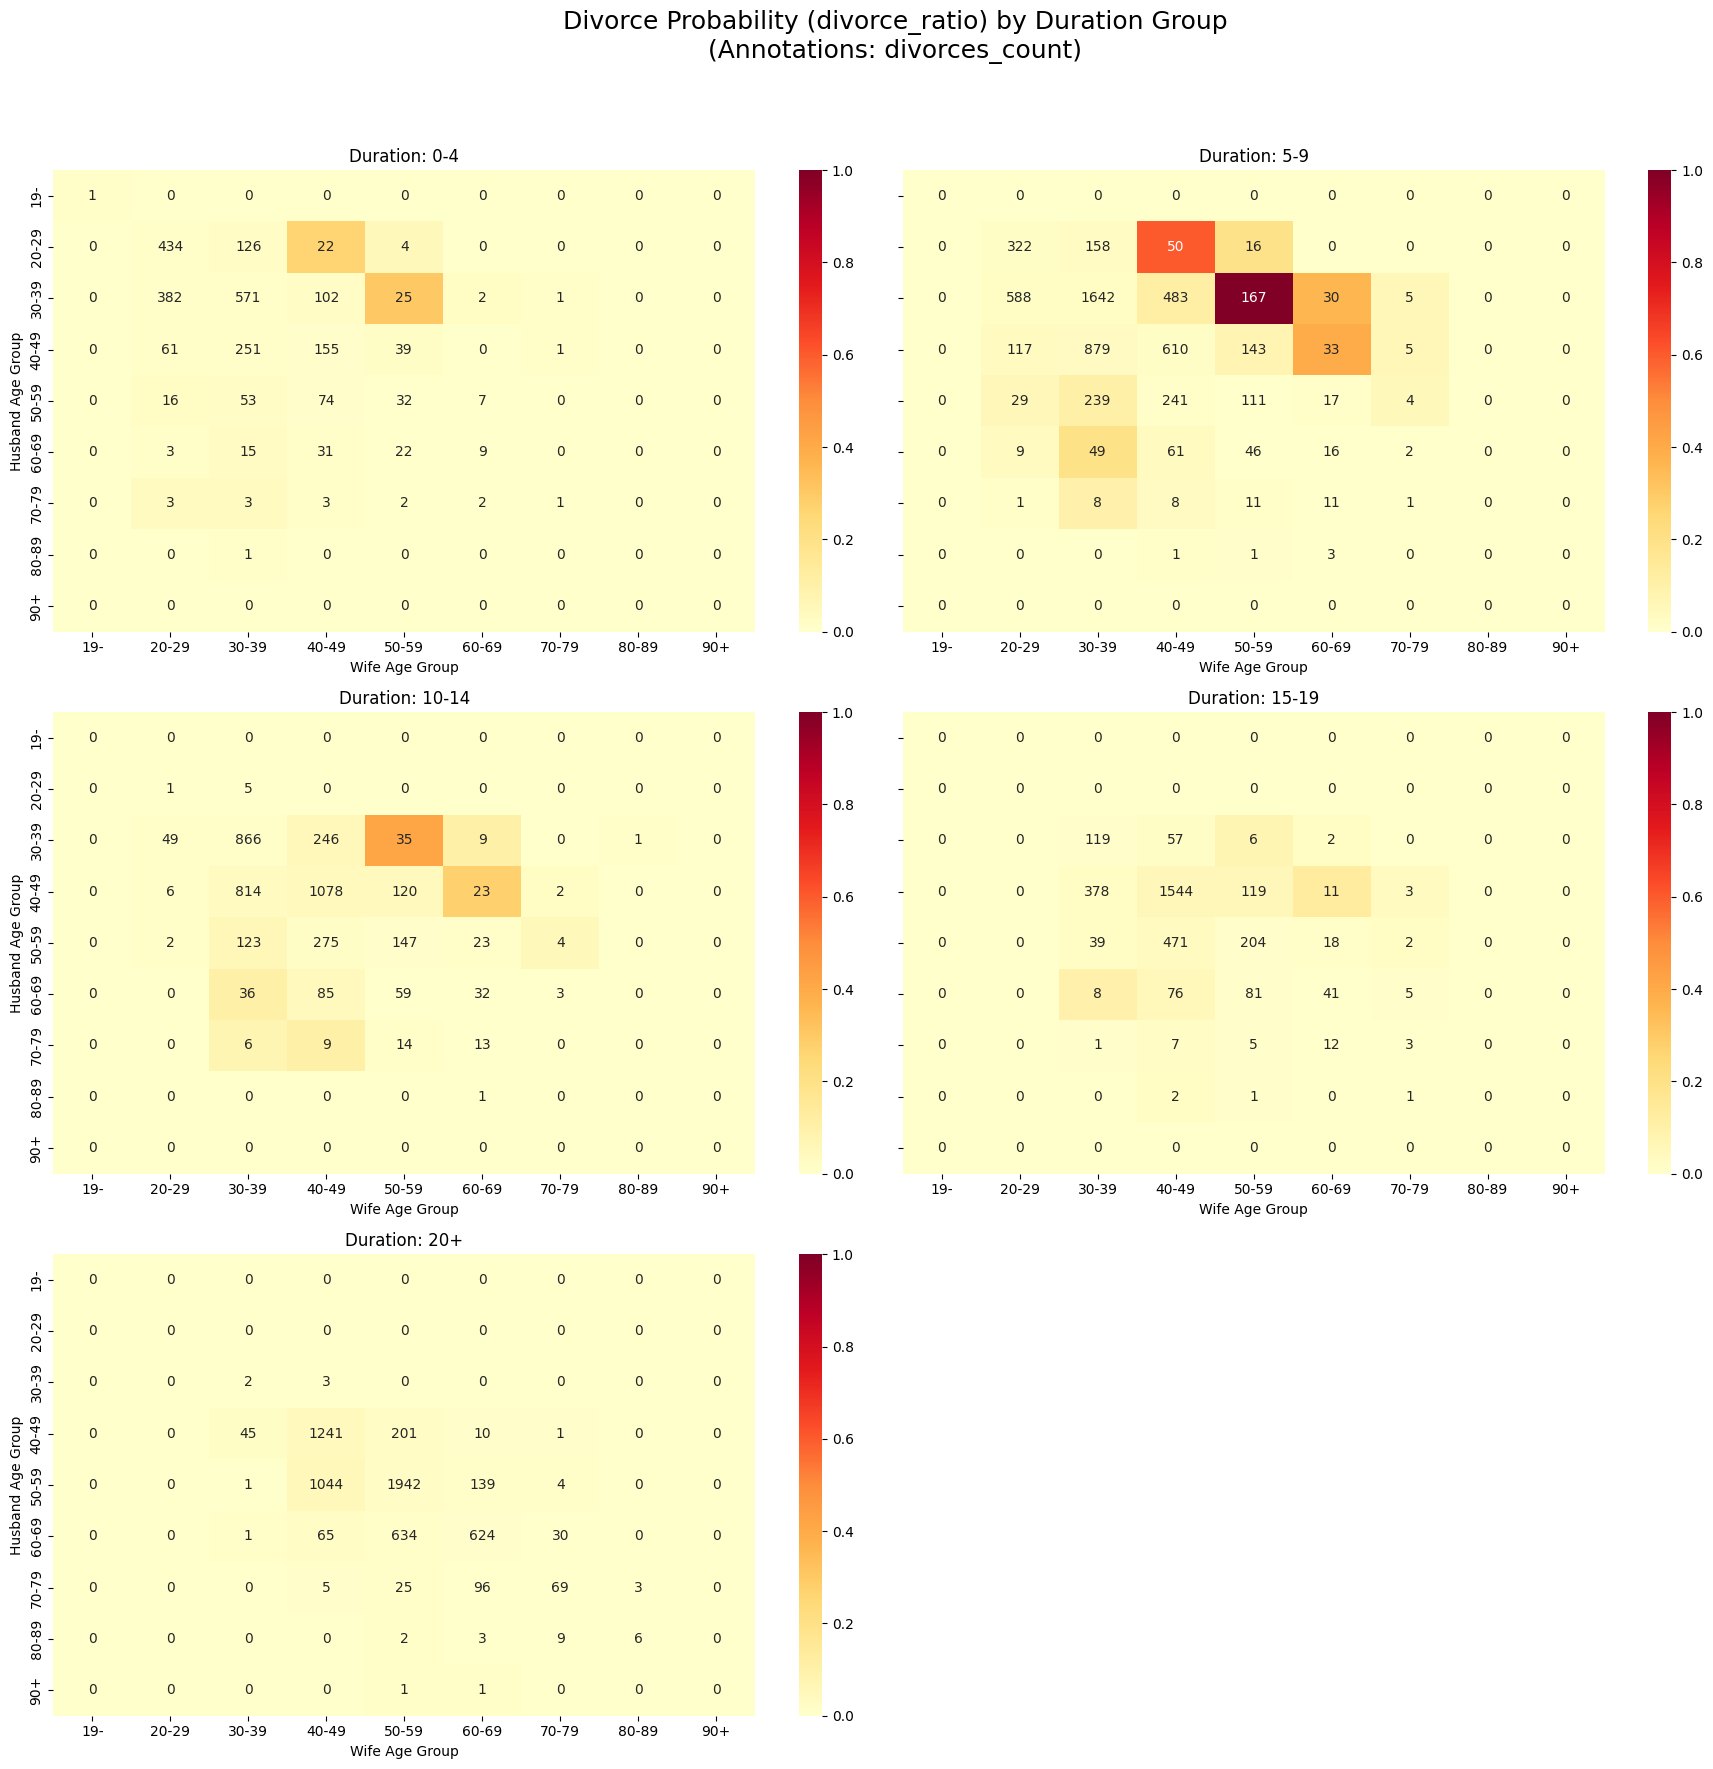

In [ ]:
#### HEATMAPS DIVORCE PROBABILITY - SPLIT DURATION ####
# Get unique duration groups in the order they appear
duration_groups = divorce_probability['duration'].unique()
# Set up a 3x2 grid for the plots (6 subplots)
fig, axes = plt.subplots(3, 2, figsize=(18, 18), sharey=True)
axes = axes.flatten()  # Flatten to easily index

for i, duration in enumerate(duration_groups[:6]):  # Only plot up to 6 durations
    data = divorce_probability[divorce_probability['duration'] == duration]
    # Pivot for heatmap values and annotations
    heatmap_data = data.pivot_table(
        index='age_group_m', columns='age_group_w', values='divorce_ratio', fill_value=0
    )
    annot_data = data.pivot_table(
        index='age_group_m', columns='age_group_w', values='divorces_count', fill_value=0
    )
    ax = axes[i]
    sns.heatmap(
        heatmap_data,
        annot=annot_data,
        fmt=".0f",
        cmap="YlOrRd",
        ax=ax,
        vmin=0,
        vmax=1
    )
    ax.set_title(f'Duration: {duration}')
    ax.set_xlabel('Wife Age Group')
    if i % 2 == 0:
        ax.set_ylabel('Husband Age Group')
    else:
        ax.set_ylabel('')

# Hide any unused subplots if there are less than 6 duration groups
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle('Divorce Probability (divorce_ratio) by Duration Group\n(Annotations: divorces_count)', fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Fitted amplitude A   = 1.622
Fitted degrees ν      = 4.368
Fitted scale s        = 10.37


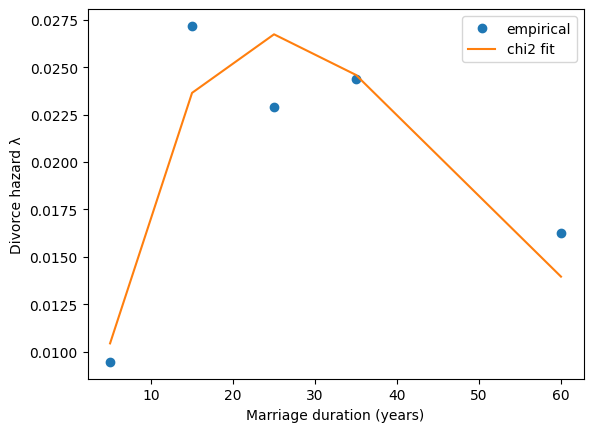

Duration≈5.0 ⇒ p_divorce≈0.010
Duration≈15.0 ⇒ p_divorce≈0.023
Duration≈25.0 ⇒ p_divorce≈0.026
Duration≈35.0 ⇒ p_divorce≈0.024
Duration≈60.0 ⇒ p_divorce≈0.014


In [ ]:
#### TEST TO FIT CHI2 DISTRIBUTION TO DIVORCE HAZARD - FAILED #### 

bin_edges = np.array([0, 5, 10, 15, 20, 40])  # final bin “20+” we pick e.g. 100
midpoints = (bin_edges[:-1] + bin_edges[1:]) /1
lambda_emp = divorce_ratio['divorce_ratio'].to_numpy()

# lambda_emp = divorce_ratio_by_year.loc[divorce_ratio_by_year.year_since_marriage < 41, 'divorce_ratio_roll7'].to_numpy()
# midpoints = divorce_ratio_by_year.loc[divorce_ratio_by_year.year_since_marriage < 41, 'year_since_marriage'].to_numpy()


from scipy.stats import chi2
from scipy.optimize import minimize

def chi2_hazard(params, d, lamb_emp):
    A, nu, s = params
    # force positivity
    A = np.abs(A)
    nu = np.abs(nu)
    s = np.abs(s)
    # model hazard
    lamb_model = A * chi2.pdf(d, df=nu, scale=s)
    # SSE
    return np.sum((lamb_emp - lamb_model)**2)

# initial guess: amplitude ~ max(lambda), nu~2, scale~10
x0 = [lambda_emp.max(), 2.0, 10.0]

res = minimize(chi2_hazard, x0,
               args=(midpoints, lambda_emp),
               bounds=[(1e-2,None),(1e-2,None),(1e-2,None)])
A_hat, nu_hat, s_hat = np.abs(res.x)

print(f"Fitted amplitude A   = {A_hat:.4g}")
print(f"Fitted degrees ν      = {nu_hat:.4g}")
print(f"Fitted scale s        = {s_hat:.4g}")


# model at midpoints
lambda_fit = A_hat * chi2.pdf(midpoints, df=nu_hat, scale=s_hat)

plt.plot(midpoints, lambda_emp, 'o', label='empirical')
plt.plot(midpoints, lambda_fit, '-', label='chi2 fit')
plt.xlabel('Marriage duration (years)')
plt.ylabel('Divorce hazard λ')
plt.legend()
plt.show()

# finally convert hazard→yearly probability:
p_fit = 1 - np.exp(-lambda_fit)
for d, pk in zip(midpoints, p_fit):
    print(f"Duration≈{d:.1f} ⇒ p_divorce≈{pk:.3f}")

In [ ]:
### KIDS LEAVING HOME PROBABILITY CALCULATION - FIT TO WEIBULL DISTRIBUTION - FAILED

import numpy as np
from scipy.optimize import minimize

# dataset obtained from interpolating BFS data on CDF of children leaving home
leave_house_df = pd.read_csv('data/derived_leaving_parent_house_sex_age.csv', delimiter=';', encoding='latin1')
F_obs_m = np.array(leave_house_df.loc[leave_house_df.gender == 'M', 'cdf'].values)
F_obs_f = np.array(leave_house_df.loc[leave_house_df.gender == 'F', 'cdf'].values)

pdf_obs_m = np.array(leave_house_df.loc[leave_house_df.gender == 'M', 'pdf'].values)
pdf_obs_f = np.array(leave_house_df.loc[leave_house_df.gender == 'F', 'pdf'].values)

ages_obs = np.arange(18, 31, 1)

# Weibull CDF: F(t; alpha, k) = 1 - exp(-(t/alpha)**k)
def weibull_cdf(t, alpha, k):
    return 1 - np.exp(-(t / alpha) ** k)

# Objective: minimize sum of squared errors between model and observed F
def objective(params):
    alpha, k = params
    F_model = weibull_cdf(ages_obs, alpha, k)
    return np.sum((F_model - F_obs) ** 2)

# Initial guess for alpha and k
initial_guess = [25.0, 2.0]
results = {}
alpha_fits = {}
k_fits = {}

for i,g in enumerate(['f', 'm']):
    # Set observed cumulative proportions
    F_obs = globals()[f"F_obs_{g}"]

    # Fit parameters
    results[i] = minimize(objective, initial_guess, bounds=[(1e-3, None), (1e-3, None)])
    alpha_fits[i], k_fits[i] = results[i].x

    print(f"Fitted parameters for !!{g.upper()}!!:\n  alpha = {alpha_fits[i]:.3f}\n  k     = {k_fits[i]:.3f}\n")

  
    # Compute annual probabilities p(a) = F(a) - F(a-1) for ages 18 through 30
    ages = np.arange(18, 31)
    globals()[f"F_values_{g}"] = weibull_cdf(ages, alpha_fit, k_fits[i])
    globals()[f"F_prev_{g}"] = weibull_cdf(ages - 1, alpha_fit, k_fits[i])
    globals()[f"p_year_{g}"]= globals()[f"F_values_{g}"] - globals()[f"F_prev_{g}"]

Fitted parameters for !!F!!:
  alpha = 23.573
  k     = 7.207

Fitted parameters for !!M!!:
  alpha = 25.718
  k     = 5.658



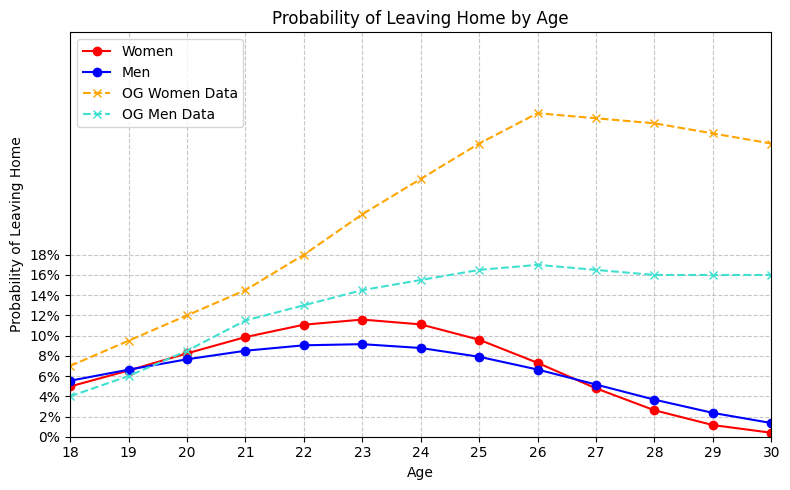

In [ ]:
# plot the PDF for both women and men
plt.figure(figsize=(8, 5))
plt.plot(np.arange(18, 31), p_year_f, marker='o', linestyle='-', color='red', label='Women')
plt.plot(np.arange(18, 31), p_year_m, marker='o', linestyle='-', color='blue', label='Men')
plt.plot(np.arange(18, 31), pdf_obs_f, marker='x', linestyle='--', color='orange', label='OG Women Data')
plt.plot(np.arange(18, 31), pdf_obs_m, marker='x', linestyle='--', color='turquoise', label='OG Men Data')
plt.title('Probability of Leaving Home by Age')
plt.xlabel('Age')
plt.ylabel('Probability of Leaving Home')
plt.xticks(np.arange(18, 31, 1))
plt.yticks(np.arange(0, 0.2, 0.02), [f"{i*100:.0f}%" for i in np.arange(0, 0.2, 0.02)])
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(18, 30)
plt.ylim(0, 0.4)
plt.legend()
plt.tight_layout()
plt.show()

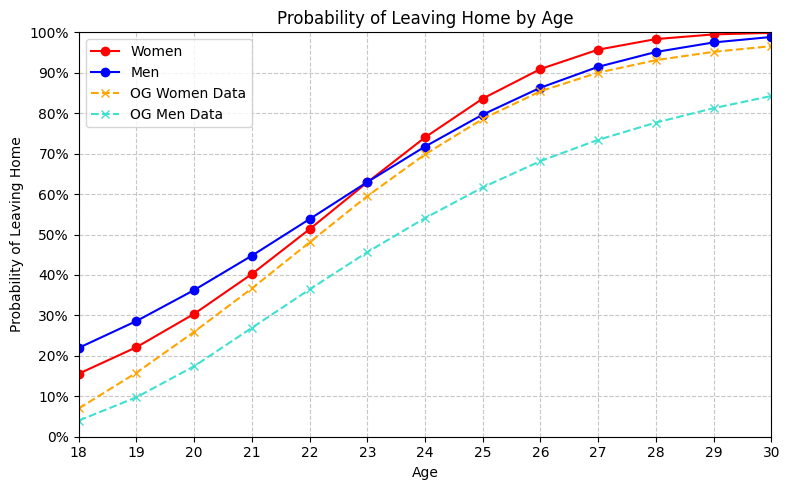

In [ ]:
# plot the CDF for both women and men
plt.figure(figsize=(8, 5))
ages = np.arange(18, 31)
plt.plot(ages, F_values_f, marker='o', linestyle='-', color='red', label='Women')
plt.plot(ages, F_values_m, marker='o', linestyle='-', color='blue', label='Men')
plt.plot(ages, F_obs_f, marker='x', linestyle='--', color='orange', label='OG Women Data')
plt.plot(ages, F_obs_m, marker='x', linestyle='--', color='turquoise', label='OG Men Data')
plt.title('Probability of Leaving Home by Age')
plt.xlabel('Age')
plt.ylabel('Probability of Leaving Home')
plt.xticks(np.arange(18, 31, 1))
plt.yticks(np.arange(0, 1.1, 0.1), [f"{int(i*100)}%" for i in np.arange(0, 1.1, 0.1)])
plt.grid(True, linestyle='--', alpha=0.7)
plt.xlim(18, 30)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# as an example --> print MY family 
get_hh_memberships_t(memberships_df, 3, 2017)

,person_id,household_id,start_date,end_date,role,leave_cause,htype,marital_status,marriage_date
membership_id,,,,,,,,,


In [ ]:
active  = get_active_hhs_memberships_t(memberships_df, 2017)     # problem with htype 30 & 40 --> not well categorized
get_htype_dict_t(active, 2017)

{100002: 10,
 100004: 220,
 100005: 220,
 100008: 220,
 100012: 10,
 100014: 10,
 100016: 210,
 100019: 220,
 100026: 220,
 100029: 220,
 100037: 210,
 100039: 10,
 100042: 10,
 100044: 220,
 100046: 210,
 100047: 210,
 100049: 210,
 100050: 220,
 100055: 210,
 100056: 210,
 100058: 220,
 100061: 10,
 100063: 220,
 100065: 10,
 100068: 220,
 100071: 10,
 100074: 230,
 100078: 220,
 100084: 230,
 100087: 10,
 100098: 220,
 100099: 220,
 100103: 230,
 100108: 210,
 100109: 220,
 100120: 10,
 100122: 230,
 100128: 10,
 100137: 10,
 100139: 210,
 100141: 220,
 100154: 220,
 100159: 220,
 100160: 210,
 100161: 210,
 100168: 230,
 100172: 210,
 100174: 220,
 100175: 220,
 100180: 210,
 100185: 220,
 100194: 230,
 100202: 220,
 100203: 220,
 100207: 10,
 100208: 10,
 100209: 10,
 100210: 10,
 100216: 10,
 100217: 10,
 100219: 210,
 100221: 210,
 100229: 10,
 100236: 220,
 100240: 220,
 100246: 10,
 100253: 220,
 100258: 230,
 100264: 210,
 100267: 220,
 100269: 220,
 100272: 220,
 100273: 10,